<a href="https://colab.research.google.com/github/BlancaCC/Computer-vision/blob/main/P4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3 
Autor: Blanca Cano Camarero 
Fecha: 20-12-21

Nota: esta práctica no ha sido ejecutada en colab, sino en local ya que se disponía de una gráfica integrada, en concreto el hardware usado ha sido un chip M1 de 16 núcleos de GPU. 



# Apartado 1: BaseNet en CIFAR1000

Convolucional, es decir, Conv2D.(normal y atrous)
Agrupación: Local y Global MaxPooling2D and AveragePooling2D().
Densa (lineal), es decir, Fully connected
Activaciones no lineales, p.e. relu, leaky relu, etc
Aplanar, es decir, Flatten.
Normalización del batch, p.e. BatchNormalization.
Regularización: p.e. Dropout



Comprobamos que el tamaño de test y entrenamiento son los pedidos en el enunciado: 
Shape de entrenamiento:  (12500, 25) Shape de test:  (2500, 25)


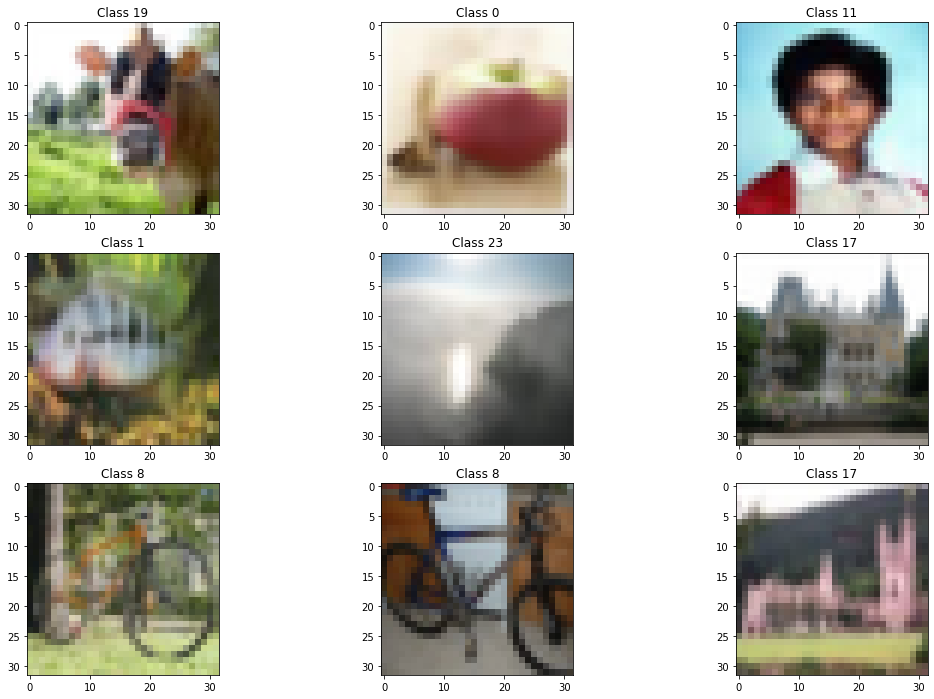

In [2]:
'''EJECUTAR para probar los modelos 
'''
#Importamos los paquetes necesarios para toda la práctica
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization,Dropout,Input, Dense, MaxPooling2D, Flatten, UpSampling2D
# Importar el optimizador a usar
from tensorflow.python.keras.optimizers import *
# Importar el conjunto de datos
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

# Importar el optimizador a usar
# TODO comentar https://keras.io/api/optimizers/sgd/
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split

######### variables globales  
# porcentaje de entrenamiento que utilizará como validación
porcentaje_validacion = 0.1
num_classes = 25
SEED = 1
# inicializamos  semillas aleatorias al mismo valor
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# A partir de aquí has el final de la celda seguimos el esquema de la parte 1 y 2

#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función sólo se le llama una vez. Devuelve 4 vectores conteniendo,
# por este orden, las imágenes de entrenamiento, las clases de las imágenes
# de entrenamiento, las imágenes del conjunto de test y las clases del
# conjunto de test.

def cargarImagenes():
  # Cargamos Cifar100. Cada imagen tiene tamaño (32, 32, 3).
  # Nos vamos a quedar con las imágenes de 25 de las clases.
  
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  train_idx = np.isin(y_train, np.arange(num_classes))
  train_idx = np.reshape(train_idx,-1)
  x_train = x_train[train_idx]
  y_train = y_train[train_idx]
  
  test_idx = np.isin(y_test, np.arange(num_classes))
  test_idx = np.reshape(test_idx, -1)
  x_test = x_test[test_idx]
  y_test = y_test[test_idx]
  
  # Transformamos los vectores de clases en matrices. Cada componente se convierte en un vector
  # de ceros con un uno en la componente correspondiente a la clase a la que pertenece la imagen.
  # Este paso es necesario para la clasificación multiclase en keras.
  y_train = np_utils.to_categorical(y_train, 25)
  y_test = np_utils.to_categorical(y_test, 25)
  
  return x_train, y_train, x_test, y_test

#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy

#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist, titulo1=None, titulo2=None):
  '''
  Esta función pinta dos gráficas, una con la evolución de la función
 de pérdida en el conjunto de train y en el de validación, y otra
 con la evolución del accuracy en el conjunto de train y en el de
 validación. Es necesario pasarle como parámetro el historial
del entrenamiento del modelo (lo que devuelven las funciones
 fit() y fit_generator()).

  Historial contiene un diccionario, donde para un entrenamientod de dos épocas prodría ser de la forma: 
  'accuracy': [0.3411555588245392, 0.3743111193180084],
 'loss': [2.2396469116210938, 2.114685535430908],
 'val_accuracy': [0.3456000089645386, 0.376800000667572],
 'val_loss': [2.209703207015991, 2.1312973499298096]}
  '''

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  if(titulo1 != None):
    plt.title(titulo1)
  plt.show()
  

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  if(titulo2 != None):
    plt.title(titulo2)
  plt.show()
  
# Cargamos imágenes y vemos su tamaño   
x_train, y_train, x_test, y_test =  cargarImagenes()
print('Comprobamos que el tamaño de test y entrenamiento son los pedidos en el enunciado: ')
print('Shape de entrenamiento: ', y_train.shape, 'Shape de test: ', y_test.shape)

#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
plt.show()


# Ejercicio 1 
## Definición del modelo BASENET
Para este ejercicio trabajaremos con el modelo BaseNet que consta de dos módulos convolucionales, la descripción precisa es la siguiente: 

*Tabla 0*: Esquema de las capas ocultas de la red a implementer  

|Layer | Layer type | tamaño kernel | input / output dim | input/output channels |
|:-: | :-: | :-:  | :-:  | :-: |
|1 | conv2d  | 5 | 32/28 | 3 / 6 | 
|2 | Relu  |  | 28/28 |   |  
|3 | MaxPooling2D | 2 | 28 / 14 | |  
|4 | conv2d  | 5 | 14/10 | 6 / 16 | 
|5 | Relu  |  | 10/10 |   |  
|6 | MaxPooling2D | 2 | 10 / 5 | |
|7 | Linear |  | 400/50 |   |  
|8 | Relu  |  | 50/50 |   |  
|9 | Lineal  |  | 50/25 |   |   


  

## Descripción teórica y de uso en keras de cada capa    

### Clase `Sequential`  

Documentación:  

- [9]Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/models/sequential/  

Necesitaremos primero definir una clase `Sequential` en la que poder alamcenar la cola de capas que se deberán de ir aplicando. 

`tf.keras.Sequential(layers=None, name=None)`  

### Convolución 2D  

Documentación: 
- [10] Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/layers/convolution_layers/convolution2d/  

Descripcion:  
Esta capa crea un kernel de convolución que se aplica a la capa de entrada produciendo un tensor de salida.    

Los argumentos soportados por keras son los siguientes: 

```python
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True, 
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

```

Parámetros a tener en cuenta: 
- `filters`: Valor entero que indica la dimensionalidad de salidad (el valor a la derecha de la última columna de la tabla), este en verdad indica el número de filtros que aplicarle.  

- Si `use_bias = True` un vector de sesgo es añadido, como en nuestro caso no se especifica nada lo dejaremos en blanco.  
- Puede añadirse una función de activación que se aplicará a la salida gracias a `activation`. 

- Si es la primera capa en el modelo debe inicializarse `input_shape` con una tupla que recoja los tamaños siempre que ésta no tenga la variable `size` (como es nuestro caso).   

- `data_format` será el parámetro que convenga si la dimensión de los canales va al principio o al final, los parámetros que admite son los strings: `'channels_first'` o `'channels_last'`. Puede consultase y modificar con: `tf.keras.backend.image_data_format()`.  **En nuestro caso usaremos convenio `channels_last`* por seguir la notación de teoría.**

Por lo que nuestro input channel será del tipo `channels_last` y concretamente `(32,32,3)` ya que las imágenes son de tamaño 32x32 y además están a color. 

Comentaremos el significado de más parámetros conforme los vayamos necesitando. 

## Relu    

- [11] Documentación oficial de keras sobre las funciones de activación día 18-12-21: https://keras.io/api/layers/activations/   

Cuando se hace referencia a relu se refiere a que se aplique tal función de activación a la salida. Esto puede hacerse equivalentemente de dos maneras:  

1. Si aparece después de una capa de Conv2D, en la función de queras que implementa la convolución añadir el arguemento `activation=relu`.   

2. Añadiendo la capa ` Activation("relu")` directamente al modelo.   

Durante nuestra implementación obtaremos por el primer método. 

### En qué consiste tal función de activación  

Como se ha visto en teoría una función de activación es una función que se encarga de transformar al salida,  en el lcaso de una relu esta es de la forma $f(x) = max(0, x)$ 

La mayor ventaja que aporta esta función es su bajo coste computacional. 

## Maxpooling   

Documentanción: 
- [12] Página oficial de keras: Maxpooling 2d, consultada a día 18-12-21
https://keras.io/api/layers/pooling_layers/max_pooling2d/  

Como se ha visto en teoría consiste en la reducción de dimensionalidad del input. 

Para su implementación utilizaremos la función `MaxPooling2D` de keras que admite los siguientes parámetros: 

```python
tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid", data_format=None, **kwargs
)

```    


## Flatten    

- [13] Documentación oficial de keras sobre *flatten layer*, consultada a día 18-12-21: https://keras.io/api/layers/reshaping_layers/flatten/  

Esta capa no se especifica en la arquitectura pero es necesara añadirla antes de la capa 7. 

Nos permitirá transformar un input de  $5 \times 5 \times 16$ a 400, es decir transformará la entrada a un vector 1D. 

A partir de aquí comienza la capa densamente conectada.   


### Consideraciones sobre los parámetros  

Sobre `padding`, según se indica en la documentación oficial puede tomar dos valores posibles:  

- `padding = "valid"` en este caso no se aplica ningún padding (ie padding = 0).  Por lo que la salida vendría dada por `output_shape = math.floor((input_shape - pool_size) / strides) + 1 (when input_shape >= pool_size)`. 

- `padding = "same"` se intenta añadir un padding de ceros equilibrado en los extremos de manera que la entrada tenga el mismo tamaño que la salida.   

En nuestro caso se utilizará siempre `padding = "valid"` por los requisitos de input out que se nos piden. 

## Softmax

Documentación:
- [14] Oficial de keras sobre *softmax*, consultada a día 18-12-21:
https://keras.io/api/layers/activation_layers/softmax/  
- [15] Bridle, J.S. (1990a). Probabilistic Interpretation of Feedforward
   Classification Network Outputs, with Relationships to Statistical Pattern
   Recognition. In: F.Fogleman Soulie and J.Herault (eds.), Neurocomputing:
   Algorithms, Architectures and Applications, Berlin: Springer-Verlag, pp.
   227-236.   

Hace referencia a la función de activación. Aunque no se especifica explícitamentente en la tabla de la arquitectura es necesario añadirla ya que se está afrontando un problema de clasificación. Esto se debe a que la función *softmax* es una generalización de la función exponencial y que en teoría de la probabilidad sirve para representar una distribución de probabilidad sobre $k$ posibles salidas. 

Se puede definir de la siguiente manera: 

$\sigma: \mathbb {R}^K \longrightarrow [0,1]^ K$

$$\sigma (x)_j = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}}$$ 

para cada componente j ésima del vector $x$.


## Observaciones  sobre la tabla que representa la arquitectura.  

1. No se precisa información como el tamaño de stride o padding en ciertas capas que permiten tal configuraciones; como lo son  las de convolución 2D o MaxPooling2D. Es por ello que se tomarán los valores por defecto (cero de padding y 1 de stride). 

Las tablas indicadoras muestran información redundante ya que en las distintas capas la siguiente información es equivalente: 

- En **convolución**: Conocer el tamaño de kernel ($K$) y la salida ($w_o$) entrada($w_i$) ya  que vienen dadas por $w_o = ( w_i - K +2P)/S +1$  con $S=1$ el stride y $P=0$ el padding. 
- Dimensión de entrada o salida de una **capa relu o linear**, ya que no las modifica. 
- En **maxPooling** el tamaño del kernel y la salida y entrada.   

3. Las celdas de la tabla vacía son coherentes con la teoría. 
x


### Declaración del modelo

In [3]:
class BaseNet:
    """Modelo base del que partimos, y que tenemos que mejorar"""
    
    def __init__(self):
        pass
    
    def create_model(self):
        ''' Creamos el modelo básico inicial siguiendo el esquema indicado
        '''
        # necesario introducir el tamaño inicial 
        # Calculamos input shape 
        # las imágenes son de 32x32x3 según la documentación de prácticas, luego 
        input_shape = (32,32,3) 

        # Descripción del modelo 
        model = Sequential(name='BaseNet')
        # capa 1 y 2 
        model.add(Conv2D( filters= 6, # parámetro de output channels  
                        kernel_size=(5, 5),
                        activation='relu', # capa 2 función activación
                        input_shape=input_shape) # parámetro necesario por tratarse de la priemera capa
        ) 
        # capa 3 Maxpooling2D 2x2
        model.add(MaxPooling2D(pool_size=(2, 2), 
                            padding="valid") # queremos que se reduzca dimensionalidad
        )
        # Capa 4 y 5 
        model.add(Conv2D( filters= 16, # parámetro de output channels  
                        kernel_size=(5, 5),
                        activation='relu', # capa 5 función activación
                        input_shape=input_shape) # parámetro necesario por tratarse de la priemera capa
        ) 
        # Capa 6 Maxpooling2D 2x2
        model.add(MaxPooling2D(pool_size=(2, 2), 
                            padding="valid") # queremos que se reduzca dimensionalidad
        )
        # Capa 7
        model.add( Flatten() )
        # Capa 8 
        model.add(Dense(units = 50, activation='relu'))
        # Capa 9 
        # Capa final de clasificación
        model.add(Dense(num_classes, activation='softmax'))

        return model
    
model = BaseNet().create_model()

print('Imprimimos tabla resumen ')
model.summary()



Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Imprimimos tabla resumen 
Model: "BaseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                 

2021-12-24 18:33:29.457963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-24 18:33:29.458113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Obsérvese que para la arquitectura de BaseNet el número total de parámetros es de 24197 [Referencia 1]

# Apartado segundo del ejercicio primero
Una vez definido el modelo, proseguiremos con su entrenamiento, cálculo de *accuracy* y función de  pérdida para el conjunto de test.  

## Entrenamiento  

Para el entrenamiento de una red neuronal es necesario definir: 
1. Optimizador con el que minimizar el error. 
2. Tamaño de batch. 
3. Número de épocas.
4. Validación, porcentaje y método.   

### Optimizador 

Bibliografía:   

- [1] Oficial de keras sobre *optimizers* consultada a día 19-12-21: https://keras.io/api/optimizers/  

- [2] Artículo: *Comparative Study of First Order Optimizers for
Image Classification Using Convolutional Neural
Networks on Histopathology Images* de autores *Ibrahem Kandel, Mauro Castelli and Aleš Popoviˇ* Publicado el 8 de septiembre de 2020. DOI:  https://doi.org/10.3390/jimaging6090092  

- [3] Saleem MH, Potgieter J, Arif KM. Plant Disease Classification: A Comparative Evaluation of Convolutional Neural Networks and Deep Learning Optimizers. Plants (Basel). 2020 Oct 6;9(10):1319. doi: 10.3390/plants9101319. PMID: 33036220; PMCID: PMC7599959.

- [4] Yaqub M,Jinchao F, Zia M. State-of-the-Art CNN Optimizer for Brain Tumor Segmentation in Magnetic Resonance Images. Brain Sci. 2020 Jul 3;10(7):427. doi: 10.3390/brainsci10070427.

- [5] Oficial de keras sobre el optimizador Adam, consultado a días 19-12-21: https://keras.io/api/optimizers/adam/

Los contenido en la biblioteca de keras son los siguientes [1]: 

- SGD
- RMSprop
- Adam
- Adadelta
- Adagrad
- Adamax
- Nadam
- Ftrl  

Tras indagar cuál podría ser mejor candidato parece ser que los optimizadores adaptativos (salvo AdaGrad) resultan mejores. [2]  Además el de Adam es al que varias fuentes [3] [4] [5] otorgan mejores resultados. 

Nos basaremos pues en el optimizador Adam [5], siendo conscientes de que estos artículos solo son una indicación ya que ninguno nos dice que Adam es mejor para nuestro problema particular de clasificación. 

Los argumentos que recibe este optimizados son: 

```python 
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```  

Como para este ejercicio no se pide optimizar el modelo, solo entrenarlo, lo dejaremos con los valores por defecto y en apartados posteriores trataremos el ajuste de los mismos.  

### Tamaño de batch  

Para esta primera aproximación utilizaremos un valor a priori de 32 ya que como vimos en aprendizaje automático era una buena heurística. 

### Validación 

En el guión de prácticas se pide un porcentaje de validación del 10%, que además nos parece un valor razonable por el tamaño de entrenamiento. Será pues éste el que utilicemos.   

Por tratarse de un problema de clasificación



## API modelo de entrenamiento   

Documentación: 

- [6] Documentación oficial de keras sobre *Model training APIs*, consultada el 19-12-21: https://keras.io/api/models/model_training_apis/

- [7] Documentación oficial de keras sobre *Losses*, consultada el 19-12-21: https://keras.io/api/losses/  

- [8] Documentación oficial de keras sobre *CategoricalCrossentropy class*, consultada el 19-12-21: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class

Una vez seleccionado el optimizador es necesario configurar los parámetros para su entrenamiento. 

Los argumentos que admiten son [6]: 

```python
Model.compile(
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs
) 
```  

### Loss  


Hace referencia a la función de pérdida, durante el entrenamiento se busca minimizar su error. [7]   

Existen distintos tipos: 
- Probabilistas. 
- De regresión.
- *Hinge losse*.

Por el ámbito  del problema utilizaremos los probabilistas. 


Para los cuales están disponible (aunque es posible usar uno propio): 

- BinaryCrossentropy class
- CategoricalCrossentropy class
- SparseCategoricalCrossentropy class
- Poisson class
- binary_crossentropy function
- categorical_crossentropy function
- sparse_categorical_crossentropy function
- poisson function
- KLDivergence class
- kl_divergence function


Vamos a seleccionar *CategoricalCrossentropy* [8] ya que además es utilizada para problemas de clasificación y fue la indicada en teoría. 

Los argumentos que admite son [8]: 

```python
tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)
```

## Entrenamiento del modelo   
Para su entrenamiento se han seguido las funciones indicadas en las diapositivas de prácticas y la documentación de queras [6]. 


In [4]:
#########################################################################
#########           Variables globales necesarias               ######### 
#########################################################################
# valor por defecto para batch_size en keras al hacer
tam_batch = 32
# número de epocas a entrenar el modelo
epocas = 15
#########################################################################
######### DEFINICIÓN DEL OPTIMIZADOR Y COMPILACIÓN DEL MODELO ###########
#########################################################################

# incluir model.compile()
optimizador = Adam() 

# es multi clase, luego usamos categorical_crossentropy como perdida

model.compile( loss = keras.losses.categorical_crossentropy,
              optimizer = optimizador,
              metrics = ["accuracy"] )


# Una vez tenemos el modelo base, y antes de entrenar, vamos a guardar los 
# pesos aleatorios con los que empieza la red, para poder reestablecerlos 
# después y comparar resultados entre no usar mejoras y sí usarlas.
weights = model.get_weights() 

2021-12-24 18:33:53.139932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-24 18:33:53.264359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/15
351/352 [============================>.] - ETA: 0s - loss: 2.9242 - accuracy: 0.1509

2021-12-24 18:33:57.011027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 4s 11ms/step - loss: 2.9230 - accuracy: 0.1512 - val_loss: 2.6359 - val_accuracy: 0.2448
Epoch 2/15
352/352 [==============================] - 4s 10ms/step - loss: 2.4871 - accuracy: 0.2759 - val_loss: 2.4237 - val_accuracy: 0.3072
Epoch 3/15
352/352 [==============================] - 4s 10ms/step - loss: 2.2921 - accuracy: 0.3317 - val_loss: 2.2605 - val_accuracy: 0.3376
Epoch 4/15
352/352 [==============================] - 4s 10ms/step - loss: 2.1616 - accuracy: 0.3671 - val_loss: 2.1615 - val_accuracy: 0.3712
Epoch 5/15
352/352 [==============================] - 4s 10ms/step - loss: 2.0765 - accuracy: 0.3947 - val_loss: 2.1019 - val_accuracy: 0.3856
Epoch 6/15
352/352 [==============================] - 4s 10ms/step - loss: 1.9981 - accuracy: 0.4132 - val_loss: 2.0805 - val_accuracy: 0.3872
Epoch 7/15
352/352 [==============================] - 4s 10ms/step - loss: 1.9354 - accuracy: 0.4300 - val_loss: 2.0742 - val_accuracy: 0.4008
Epoch 8/15

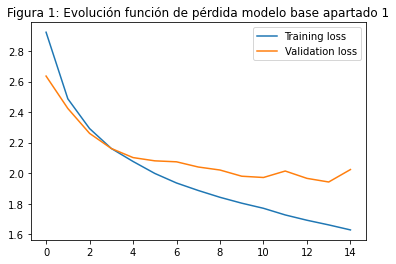

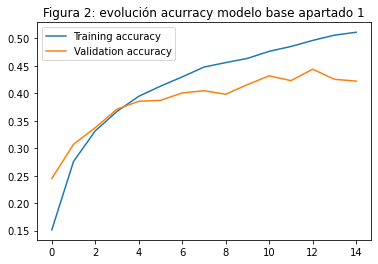

79/79 [==============================] - 0s 2ms/step
Accuracy en el conjunto test: 0.4292


2021-12-24 18:34:46.953918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [5]:
 #########################################################################
###################### ENTRENAMIENTO DEL MODELO #########################
#########################################################################

evolucion_entrenamiento = model.fit(
    x_train, y_train, 
    batch_size = tam_batch,
     epochs = epocas, 
     validation_split = porcentaje_validacion,
      verbose = 1)
# Incluir función que muestre la evolución del entrenamiento y validación
mostrarEvolucion(evolucion_entrenamiento, 'Figura 1: Evolución función de pérdida modelo base apartado 1', 'Figura 2: evolución acurracy modelo base apartado 1')

#########################################################################
################ PREDICCIÓN SOBRE EL CONJUNTO DE TEST ###################
#########################################################################

#Incluir model.evaluate() 
prediccion = model.predict(x_test, batch_size = tam_batch, verbose = 1)
#Incluir función que muestre la perdida y accuracy del test
precision_test = calcularAccuracy(y_test, prediccion)
print("Accuracy en el conjunto test: {}".format(precision_test))

## Resultados del modelo

Accuracy en el conjunto test: 0.4292  

Ademá observando la última línea de información del entrenamiento: 
`loss: 1.6280 - accuracy: 0.5114 - val_loss: 2.0235 - val_accuracy: 0.4224`

Vemos que el accuray obtenido en validación durante la última época es de 0.4224 utilizaremos este dato más adelante para comparar los modelos. 

El modelo ha sido sobre entranado, con 5 épocas hubiera sido suficiente. 

es posible reconocer el sobre entrenamiento ya que como se ve en la **Figura 1**  el error de la función de pérdida y validación decaen de igual manera hasta aproximadamente la época 5 (eje x=4 de la gráfica). Sin embargo a partir de ahí la función de pérdida de validación se no disminuye  en la misma proporción que la de training e incluso parece haber alcanzado un valle. El resultado en accuracy *Figura 2* refleja esta misma conducta. 

Por otra parte el accuracy es bastante mediocre, ya que como vimos en clase este porcentaje era incluso alcanzable sin el uso de redes neuronales. 

# Apartado 2  

Ahora el objetivo es crear, haciendo elecciones juiciosas de arquitectura e implementación, una red profunda mejorada partiendo de BaseNet. Una buena combinación de capas puede hacer que la precisión del nuevo modelo se acerque al 50% sobre nuestros datos de CIFAR-100. Para mejorar la red, puede considerar añadir cualquier combinación de entre las siguientes opciones de mejora:

## Mejoras a considerar   
Una clases util para el aumento de los datos y la normalización de los mismo es la que se muestra a continuación 

### Clase ImageDataGenerator

Documetación: 
- [16] Página oficia de tensorflow, sobre ImageDataGenerator https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator consultada a día 20-12-21

Para estas pruebas  empleará la clase `ImageDataGenerator` [16]

Que admite los siguientes argumentos: 

```python
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0,
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0,
     fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, 
    rescale=None,
    preprocessing_function=None, 
    data_format=None, validation_split=0.0, 
    dtype=None
)
```  

Los que nos son relevantes son: 

- `featurewise_center`	Boolean. Set input mean to 0 over the dataset, feature-wise.
- `samplewise_center`	Boolean. Set each sample mean to 0.
- `featurewise_std_normalization`	Boolean. Divide inputs by std of the dataset, feature-wise.
- `samplewise_std_normalization`	Boolean. Divide each input by its std.
- `horizontal_flip`	Boolean. Randomly flip inputs horizontally.
- `vertical_flip`	Boolean. Randomly flip inputs vertically.
- `validation_split`	Float. Fraction of images reserved for validation (strictly between 0 and 1).
- `zoom_range`	Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
-`rotation_range` Int. Degree range for random rotations.

Como se nos pide normalizar los datos de entrada introduciremos haremos 
`featurewise_center = True` para la media y `featurewise_std_normalization = true` para la desviación típica.   

## Mejora 1 Normalizar los datos


Normalización de los datos
Epoch 1/15
 12/352 [>.............................] - ETA: 3s - loss: 3.2506 - accuracy: 0.0443   

2021-12-21 10:49:02.255415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


347/352 [============================>.] - ETA: 0s - loss: 2.8016 - accuracy: 0.1942

2021-12-21 10:49:05.846594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 4s 11ms/step - loss: 2.7978 - accuracy: 0.1952 - val_loss: 2.6098 - val_accuracy: 0.2160
Epoch 2/15
352/352 [==============================] - 4s 11ms/step - loss: 2.4080 - accuracy: 0.3058 - val_loss: 2.3848 - val_accuracy: 0.3000
Epoch 3/15
352/352 [==============================] - 4s 11ms/step - loss: 2.1922 - accuracy: 0.3578 - val_loss: 2.2484 - val_accuracy: 0.3296
Epoch 4/15
352/352 [==============================] - 4s 11ms/step - loss: 2.0476 - accuracy: 0.3969 - val_loss: 2.1929 - val_accuracy: 0.3472
Epoch 5/15
352/352 [==============================] - 4s 11ms/step - loss: 1.9358 - accuracy: 0.4260 - val_loss: 2.0510 - val_accuracy: 0.3768
Epoch 6/15
352/352 [==============================] - 4s 11ms/step - loss: 1.8332 - accuracy: 0.4567 - val_loss: 2.0333 - val_accuracy: 0.4104
Epoch 7/15
352/352 [==============================] - 4s 11ms/step - loss: 1.7511 - accuracy: 0.4852 - val_loss: 1.9949 - val_accuracy: 0.4176
Epoch 8/15

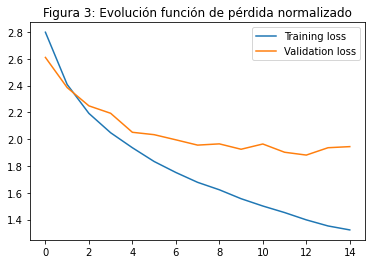

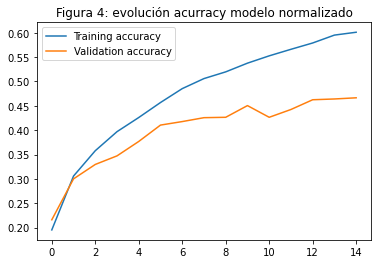

In [7]:

# valor por defecto para batch_size en keras al hacer
tam_batch = 2
# porcentaje de entrenamiento que utilizará como validación
porcentaje_validacion = 0.1
# número de epocas a entrenar el modelo
epocas = 15

# ____   Normalización _______
generador_image_normalizacion= ImageDataGenerator(
    # normalizamos los datos
    featurewise_center = True,  
    featurewise_std_normalization = True,
    validation_split = porcentaje_validacion)


generador_image_normalizacion.fit(x_train)

# reestablecemos los pesos
model.set_weights(weights)

# entrenamos con parámetros normalizados
evolucion_entrenamiento_normalizado = model.fit(
    generador_image_normalizacion.flow(x_train, y_train,subset='training'),
    validation_data=generador_image_normalizacion.flow(x_train, y_train, subset='validation'),
    epochs=epocas,
    verbose=True,
    )
mostrarEvolucion(evolucion_entrenamiento_normalizado, 'Figura 3: Evolución función de pérdida normalizado', 'Figura 4: evolución accuracy modelo normalizado')


Tras acabar el entrenamiento se ha obtenido en la última época: 
`4s 11ms/step - loss: 1.3224 - accuracy: 0.6010 - val_loss: 1.9441 - val_accuracy: 0.4664`  

Comparando los datos:  

*Tabla 1*: Resumen de resultados tras primera mejora  

Modelo | Accuracy en validación  | Tiempo empleado por época | Valor función pérdida en validación 
:-: | :-:  | :-: | :-:|
Modelo básico |  0.4224 | 4s | 2.035 
Mejora 1 |  0.4664|  4s  | 1.9441  


*Tabla 2*: Resumen de mejoras progresivas  

Modelo  | Mejora 
---| ---  
Modelo básico | Modelo inicial descrito en apartado primero  
Mejora 1 | Normalizamos por *featurewise* los datos de entrada: ahora la media y desviación típica son 0  


Como se observa con el mero hecho de normalizar los datos hemos obtenido una mejora.   
¿Qué es lo que hemos hecho? Normalizar la intensidad promedio del cada canal, de esta manera eliminamos factores como la intensidad. 

In [6]:
# Dejaremos los datos normalizados y además separaremos validación de entrenamiento para las futuras mejoras 

# ____   Normalización _______
generador_image_normalizacion= ImageDataGenerator(
    # normalizamos los datos
    featurewise_center = True,  
    featurewise_std_normalization = True,
    validation_split = 0.0) # Ahora esto es 0.0 ya que los separaremos y normalizaremos manualmente

def normalize_data(x_datas: np.ndarray, data_normalizer: ImageDataGenerator) -> np.ndarray:
    """
    Dado un conjunto de datos y un modelo para normalizar datos, devuelve el conjunto
    de datos normalizado.   
    """
    
    # Tomamos los parametros del normalizador (mean, std) y normalizamos manualmente los datos
    mean = data_normalizer.mean
    std = data_normalizer.std
     
    # Normalizamos usando estos parametros y una funcion
    # x normalizado = (x - mean) / std
    normalize_func = lambda x: (x - mean) / std
    normalized_x_datas = np.array([normalize_func(x) for x in x_datas])
    
    return normalized_x_datas
# utilizamos la función de sklearn que nos permite separar datos de entrenamiento de los de test    
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train,
    y_train,
    test_size= porcentaje_validacion,
    stratify = y_train,
    shuffle = True,
    random_state=SEED
)
# ajustamos los parámetros 
generador_image_normalizacion.fit(x_train)
# Aplicamos la normalización 
x_train_normalizados = normalize_data(x_train, generador_image_normalizacion)
x_test_normalizados = normalize_data(x_test, generador_image_normalizacion)
x_validation_normalizados = normalize_data(x_validation, generador_image_normalizacion)

### Mejora 2: Aumento de los datos   
En esta siguiente mejora aumentaremos el tamaño del dataset aplicando de manera azarosa las siguientes transformaciones de los datos:  

**Volteado las imágenes horizontalmente** con `horizontal_flip`. No se ha contemplado el volteo vertical ya que incluso para los humanos, reconocer rostros y personas de abajo a arriba es algo que no acostumbramos y que por ello podría introducir más ruido en el entrenamiento. (Aunque esta hipótesis ha sido formulada de manera teórica y habría que experimentar con ella para constatarla). 

Sería también interesante probar con **rotaciones** y **zooms** pequeños. 

En cuanto al valor para giro y zoom el valor concreto no es más que una heurística: se pretende que sea los suficientemente pequeños para que no introduzca ruido y lo suficientemente grande como para introducir más variabilidad de los datos, luego nuestra decisiones son las siguientes: 
giro de 40 grado  y zoom de rango 0.25. También podría tener interés el experimentar con cizallas, pero no se indica nada en el enunciado. 

Para esta validación no podremos utilizar las funciones anteriores tal cuál,
ya que estariamos modificando los imágenes usadas en validación, es por que ello que separaremos la función que modifique las entradas de los conjuntos de entrenamiento y validación .
Aplicaremos el aumento en los de entrenamiento y compararemos resultados con los de entrenamiento.  


Comprobemos los resultados de la experimentación: 

Normalización de los datos
Epoch 1/15
352/352 [==============================] - 4s 11ms/step - loss: 2.9052 - accuracy: 0.1584 - val_loss: 2.9180 - val_accuracy: 0.1976
Epoch 2/15
352/352 [==============================] - 4s 11ms/step - loss: 2.5441 - accuracy: 0.2564 - val_loss: 2.8033 - val_accuracy: 0.2368
Epoch 3/15
352/352 [==============================] - 4s 10ms/step - loss: 2.3586 - accuracy: 0.3060 - val_loss: 2.7716 - val_accuracy: 0.2272
Epoch 4/15
352/352 [==============================] - 4s 10ms/step - loss: 2.2582 - accuracy: 0.3372 - val_loss: 2.6529 - val_accuracy: 0.2952
Epoch 5/15
352/352 [==============================] - 4s 10ms/step - loss: 2.1664 - accuracy: 0.3608 - val_loss: 2.6792 - val_accuracy: 0.2624
Epoch 6/15
352/352 [==============================] - 4s 10ms/step - loss: 2.1095 - accuracy: 0.3804 - val_loss: 2.6409 - val_accuracy: 0.2424
Epoch 7/15
352/352 [==============================] - 4s 10ms/step - loss: 2.0495 - accuracy: 0.3938 - val_loss: 2.

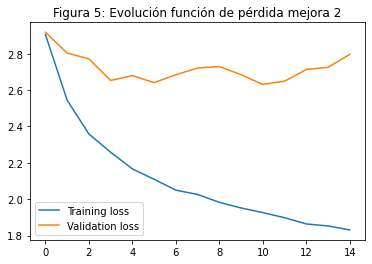

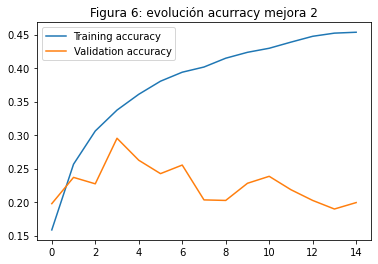

In [8]:

# valor por defecto para batch_size en keras al hacer
tam_batch = 32
# porcentaje de entrenamiento que utilizará como validación
porcentaje_validacion = 0.1
# número de epocas a entrenar el modelo
epocas = 15

# ____   Normalización y transformaciones geometricas  _______
print('Normalización de los datos')
generador_image_aumentados= ImageDataGenerator(
    # normalizamos los datos
    featurewise_center = True,  
    featurewise_std_normalization = True,
    # Añadimos datos nuevos
    horizontal_flip = True, 
    zoom_range = 0.25,
    rotation_range=10
)

generador_image_aumentados.fit(x_train)

# reestablecemos los pesos
model.set_weights(weights)
# entrenamos
evolucion_entrenamiento_normalizado = model.fit(
    generador_image_aumentados.flow(x_train_normalizados, y_train, batch_size=tam_batch),
    validation_data=(x_validation_normalizados, y_validation),
    epochs=epocas,
    verbose=True
)
mostrarEvolucion(evolucion_entrenamiento_normalizado, 'Figura 5: Evolución función de pérdida mejora 2', 'Figura 6: evolución acurracy mejora 2')



### Análisis de la mejora 2 

Durante el entrenamiento se han obtenido los siguientes resultado:
 
En la época 10: `11ms/step - loss: 1.9997 - accuracy: 0.4121 - val_loss: 2.6822 - val_accuracy: 0.2096`

Comparando los datos:  

*Tabla 3*: Resumen de resultados tras segunda mejora  

Modelo | Accuracy en validación  | Tiempo empleado por época | Valor función pérdida en validación | Accuracy entrenamiento
:-: | :-:  | :-: | :-:|
Modelo básico |  0.4224 | 3s | 2.035 | 0.5114
Mejora 1 |  0.4664|  4s  | 1.9441  | 0.6010  
Mejora 2  | 0.2096 | 4s | 2.6681 | 0.4121


*Tabla 4*: Resumen de mejoras progresivas  

Modelo  | Mejora 
---| ---  
Modelo básico | Modelo inicial descrito en apartado primero  
Mejora 1 | Normalizamos por *featurewise* los datos de entrada: ahora la media y desviación típica son 0    
Mejora 2 | Aumento de los datos  

## Conclusiones  

Por las gráficas mostradas en las *Figuras: 6 y 7*  en las que el entrenamiento mejora pero el error de validación aumentas se aprecia de nuevo un sobreentrenamiento: 
Por lo tanto concluimos que las transformaciones aplicadas a las imágenes no han introducido la variabilidad deseada, si no todo lo contrario. Esto puede deberse a que provenga de que las transformaciones no han sido las correctas o que es necesario aplicar otras técnicas antes.   

Las técnicas propuestas que reducen el overfiting son: 

- **Batchnormalization**. Las capas de Batch-normalizatión en la mayoría de los casos ayudan a reducir el sobreajuste y mejorar el entrenamiento del modelo. 
Las capas de Batch-normalizatión de Keras son una forma fácil de incorporarlas al modelo. Agregue capas de normalización después de capas lineales (conv) y antes de la capa ReLU, pero experimente también con después de las capas ReLU.
- **Dropout**: esta capa introduce regularización seleccionando de forma aleatoria un porcentaje de neuronas activas para cada mini-batch. 
Esto ayuda a que la red especialice las neuronas en informaciones especificas e independientes.

- **Early Stopping** ¿Después de cuántas épocas parar y dejar de entrenar? La discusión en stack-exhange es un buen resumen del uso de divisiones train-val- test para reducir el sobreajuste. Este blog también es una buena referencia para “early stopping”. 
Recuerde, nunca debe usar el conjunto de test en otra cosa que no sea la evaluación final. Mirando las gráficas de pérdida de entrenamiento y precisión en validación, decida cuántas épocas entrenará su modelo (evalue para ello los mínimos y máximos y locales de las gráficas de perdida y precisión, respectivamente).
 No fije demasiadas (ya que eso conduce a un sobreajuste) y tampoco muy pocas (de lo contrario, su modelo no habrá aprendido lo suficiente). Keras proporciona un criterio parametrizado para fijar sus decisiones.
Recuerde que en su informe, deberá incluir una tabla similar a la mostrada en el punto.1 para ilustrar la arquitectura de su red final. Además, deberá explicar los pasos dados con los resultados parciales obtenidos que finalmente le han llevado a introducir las modificaciones propuestas.


Sin embargo, antes de empezar a aplicarlas, puesto que se basan en cierta medida en la arquitectura de la red, nos centraremos antes en el diseño de la misma. 

### Mejora 3   Aumento profundidad: Añadiendo capas convolucionales   

Bibliografía: 
- [17] Página web toward data science, título: *Understanding and Implementing LeNet-5 CNN Architecture (Deep Learning)* url: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342 consultada a día 21-12-21 . 
- [18] Página web analyticsvidhya, titulo: *Introduction to The Architecture of Alexnet* url: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/ consultada a día 22-12-21.



Se enuncia en el enunciado: 
Experimente agregando capas convolucionales. No coloque siempre una capa de maxpool después de cada capa conv, ya que conduce a una pérdida excesiva de información por reducción del número de unidades. Si lo necesita use capas de UpSampling (Transposed Convolution) para aumentar el número de unidades.

#### Cómo se ha abordado la práctica   

De toda las opciones posibles lo que haremos será basarnos en redes neuronales dedicadas a clasificación que ya conocemos que funcionan correctamente.
si tenemos en mente la *tabla 0*, la arquitectura implementada *BaseNet* tiene mucha similitudes con la la arquitectura *Lenet* que es de la forma: 

*Tabla 5*: Arquitectura de la red neuronal Alexnet [17]

|Layer | Layer type | tamaño kernel | input / output dim | input/output channels | Función de activación   
|:-: | :-: | :-:  | :-:  | :-: | :-:   
|1 | conv2d  | 5 | 32/28 | 3 / 6 | tanh
|2| MaxPooling2D | 2 | 28 / 14 | |  sigmoid    
|3| conv2d  | 5 | 14/10 | 6 / 16 | tanh   
|4 | MaxPooling2D | 2 | 10 / 5 | | sigmoid   
|5 | conv2d  | 5 | 5/1 | 1 / 1 | tanh   
|6| FC |  |  |   |  tanh
|7 | FC  |  |  |   |   tanh   
|8 | Lineal  |  | |   |   softmax     


El número total de parámetros que dispone esta red es de : 59470  

Mientras que como hemos visto en nuestra basenet [Referencia 1] es de 24,197 parámetros. 

Podemos observar un aumento considerable, más del doble en el número de parámetros en la red. Si el tamaño de entrenamiento es lo suficientemente bueno esto podría suponer una mejora considerable.   

Puede verse también que el aumento de parámetro proviene de la capa 5 de *tabla 5*, al introducir esa nueva capa de convolución. 

Otra diferencia existente entre el modelo BaseNet y Lenet son las funciones de activación, que no solo son de naturaleza diferentes si no que además hay más en Lenet si además tenemos presente que las funciones Relu son las más simples podría plantearse su cambio para futuras comprobaciones el modificar. 

Además, basados también en la teoría la red Lenet fue superada por otras como la AlexNet que aumentaban la profundidad de sus capas convolucionales y añadía capas de dropout. 

Sea pues por el razonamiento expuesto, tratando de aproximar nuestro diseño aumentaremos el número de capas de una AlexNet. 

La arquitectura a implementar no es directa, ya que observando la arquitectura mostrada las imágenes  de entrada en una AlexNet son de 227x227x3 mientras que las nuestras son de 
32x32x3. 

Las soluciones que se nos ocurrieron para solventarlo:  

- Interpolación de la imagen de 32x32 a 227x227, sin embargo el aumento entendemos que sería demasiado grande y no aportaría demasiada información (aunque en cierta medida podría ser interesante si recordamos la interpolación inicial de las pirámides gaussianas).
- REducción del tamaño de filtro de la imagen, pero siguiendo con la misma filosofía. 

 resultando la siguiente arquitectua a implementar: 

*Tabla 6*: Esquema del modelo de mejora 3: 

 Layer (type)    |            Output Shape           |   Param #   
:-: | :-: | :-: 
 conv2d_2 (Conv2D)     |      (None, 30, 30, 8)   |      224       
 conv2d_3 (Conv2D)  |         (None, 28, 28, 16)    |    1168      
 max_pooling2d_2  |  (None, 14, 14, 16)     |  0         
 conv2d_4 (Conv2D)    |       (None, 12, 12, 32)    |    4640      
 conv2d_5 (Conv2D)     |      (None, 10, 10, 64)    |    18496     
 max_pooling2d_3 |  (None, 5, 5, 64)    |     0         
 flatten_1 (Flatten)     |    (None, 1600)      |        0         
 dense_2 (Dense)        |     (None, 50)         |       80050     
 dense_3 (Dense)        |     (None, 25)        |        1275      



In [8]:
# Implementación de la mejora 3


class ModeloModificacion3:
    """Modelo base del que partimos, y que tenemos que mejorar"""
    
    def __init__(self):
        pass
    
    def create_model(self):
        ''' Creamos el modelo básico inicial siguiendo el esquema indicado
        '''
             
        model = Sequential()

        # Pasamos de usar 5x5 a usar 3x3. Ademas, añadimos una capa adicional para compensar
        model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=(32,32,3)))
        model.add(Conv2D(16, kernel_size=3, activation='relu'))
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
            
        # Pasamos de usar 5x5 a usar 3x3. Ademas, añadimos una capa adicional para compensar
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(25, activation='softmax'))

        return model
    
modeloModificacion3 = ModeloModificacion3().create_model()

print('*Tabla 6*: Esquema del modelo de mejora 3')
modeloModificacion3.summary()



*Tabla 6*: Esquema del modelo de mejora 3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 8)         224       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)        

Puede observarse la nueva estructura, con un total de 4,648 nuevos parámetros.  

Procederemos a su entrenamiento. 
Además nos parece razonable continuar con el aumento de los datos, ya que al haber un mayor número de parámetros esto podría ser beneficioso. 



Normalización de los datos
Epoch 1/15
  1/352 [..............................] - ETA: 1:31 - loss: 3.2494 - accuracy: 0.0625

2021-12-24 18:59:39.481264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


351/352 [============================>.] - ETA: 0s - loss: 2.6803 - accuracy: 0.2233

2021-12-24 18:59:43.695482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 5s 12ms/step - loss: 2.6796 - accuracy: 0.2236 - val_loss: 2.4178 - val_accuracy: 0.2784
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 2.1826 - accuracy: 0.3582 - val_loss: 2.1829 - val_accuracy: 0.3832
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 1.9214 - accuracy: 0.4339 - val_loss: 2.0968 - val_accuracy: 0.3920
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 1.7119 - accuracy: 0.4917 - val_loss: 1.9461 - val_accuracy: 0.4312
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 1.5579 - accuracy: 0.5380 - val_loss: 1.8740 - val_accuracy: 0.4648
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4039 - accuracy: 0.5800 - val_loss: 1.9079 - val_accuracy: 0.4744
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 1.2735 - accuracy: 0.6160 - val_loss: 1.8047 - val_accuracy: 0.5008
Epoch 8/15

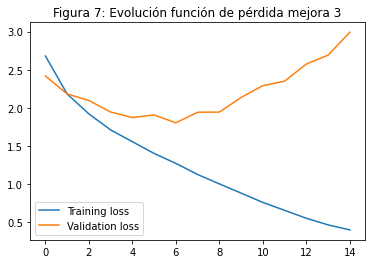

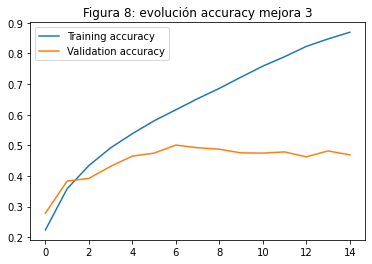

In [9]:
# ____Compilado modelo _____
optimizador = Adam() 
modeloModificacion3.compile( loss = keras.losses.categorical_crossentropy,
              optimizer = optimizador,
              metrics = ["accuracy"] )
 
# ______Entrenamiento del ModeloMejora3_____
# valor por defecto para batch_size en keras al hacer
tam_batch = 32
# número de epocas a entrenar el modelo
epocas = 15
# ____   Normalización y aumento _______
print('Normalización de los datos')
generador_image_aumentados= ImageDataGenerator(
    # normalizamos los datos
    featurewise_center = True,  
    featurewise_std_normalization = True)

generador_image_aumentados.fit(x_train)

# reestablecemos los pesos
evolucion_entrenamiento_mejora3 = modeloModificacion3.fit(
    x_train_normalizados, y_train,
    validation_data=(x_validation_normalizados, y_validation),
    epochs=epocas,
    verbose=True
)

mostrarEvolucion(evolucion_entrenamiento_mejora3, 'Figura 7: Evolución función de pérdida mejora 3', 'Figura 8: evolución accuracy mejora 3')

Los resultados obtenidos han sido: `- 4s 12ms/step - loss: 0.4026 - accuracy: 0.8693 - val_loss: 2.9909 - val_accuracy: 0.4688`
Además se muestra claramente en las *figuras 7 y8* un sobreentrenamiento que puede estar causado por demasiadas capas convolucionales o por el clasificador. 

Probaremos por tanto en la siguiente mejora reducir la capa FC. 
Probaremos por tanto técnicas de normalización y dropout, como podíamos encontrar en Alexnet


*Tabla 7*: Resumen de resultados tras segunda mejora  

Modelo | Accuracy en validación  | Tiempo empleado por época | Valor función pérdida en validación | Accuracy entrenamiento  
:-: | :-:  | :-: | :-: | :-:
Modelo básico |  0.4224 | 3s | 2.035 | 0.5114
Mejora 1 |  0.4664|  4s  | 1.9441  | 0.6010  
Mejora 2  | 0.2096 | 4s | 2.6681 | 0.4121
Mejora 3 | 0.4688  |4s  |2.9909 | 0.8693  


*Tabla 8*: Resumen de mejoras progresivas  

Modelo  | Mejora 
---| ---  
Modelo básico | Modelo inicial descrito en apartado primero  
Mejora 1 | Normalizamos por *featurewise* los datos de entrada: ahora la media y desviación típica son 0    
Mejora 2 | Aumento de los datos    
Mejora 3 | Aumento de la profundidad de las capas  


# Mejora 4  

Introducimos normalización y dropout  arquitectura que se procede a implementar es la siguiente:
 Layer (type)    |            Output Shape           |   Param #   
:-: | :-: | :-: 
 conv2d_29 (Conv2D)    |      (None, 30, 30, 8)     |    224       
 conv2d_30 (Conv2D)     |     (None, 28, 28, 16)     |   1168      
 batch_normalization_16 |  (None, 28, 28, 16)     |  64                                                        
 max_pooling2d_20  |(None, 14, 14, 16)    |   0         
 max_pooling2d_21  | (None, 7, 7, 16)      |   0                                                                   
 conv2d_31 (Conv2D)      |    (None, 5, 5, 32)   |       4640      
 conv2d_32 (Conv2D)       |   (None, 3, 3, 64)    |      18496     
 batch_normalization_17  | (None, 3, 3, 64)      |   256       
 

In [11]:
# Implementación de la mejora 4
class ModeloModificacion4:
    """Modelo base del que partimos, y que tenemos que mejorar"""
    
    def __init__(self):
        pass
    
    def create_model(self):
        ''' Creamos el modelo básico inicial siguiendo el esquema indicado
        '''
        input_shape = (32,32,3) 
        # Descripción del modelo 
        model = Sequential(name='Apartado_2_mejora_4')
        # Pasamos de usar 5x5 a usar 3x3. Ademas, añadimos una capa adicional para compensar
        model.add(Conv2D(8, kernel_size=3, activation='relu', input_shape=input_shape))
        model.add(Conv2D(16, kernel_size=3, activation='relu'))
        model.add(BatchNormalization()) 
        model.add(MaxPooling2D(pool_size=(2, 2), 
                            padding="valid") 
        )
        
        model.add(MaxPooling2D(pool_size=(2, 2)))
            
        # Pasamos de usar 5x5 a usar 3x3. Ademas, añadimos una capa adicional para compensar
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(BatchNormalization()) 
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units = 50, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        
        return model
    
modeloModificacion4 = ModeloModificacion4().create_model()

print('Imprimimos tabla resumen ')
modeloModificacion4.summary()

Imprimimos tabla resumen 
Model: "Apartado_2_mejora_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 8)         224       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                     

Epoch 1/15


2021-12-24 19:04:04.013860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - ETA: 0s - loss: 2.8966 - accuracy: 0.1514

2021-12-24 19:04:10.781049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 7s 16ms/step - loss: 2.8966 - accuracy: 0.1514 - val_loss: 2.7244 - val_accuracy: 0.1944
Epoch 2/15
352/352 [==============================] - 5s 14ms/step - loss: 2.5548 - accuracy: 0.2468 - val_loss: 2.4001 - val_accuracy: 0.2872
Epoch 3/15
352/352 [==============================] - 5s 13ms/step - loss: 2.4099 - accuracy: 0.2844 - val_loss: 2.2840 - val_accuracy: 0.3408
Epoch 4/15
352/352 [==============================] - 5s 14ms/step - loss: 2.2907 - accuracy: 0.3189 - val_loss: 2.1552 - val_accuracy: 0.3712
Epoch 5/15
352/352 [==============================] - 5s 14ms/step - loss: 2.1970 - accuracy: 0.3451 - val_loss: 2.1477 - val_accuracy: 0.3768
Epoch 6/15
352/352 [==============================] - 5s 14ms/step - loss: 2.1119 - accuracy: 0.3648 - val_loss: 2.0641 - val_accuracy: 0.3800
Epoch 7/15
352/352 [==============================] - 5s 14ms/step - loss: 2.0345 - accuracy: 0.3871 - val_loss: 2.0513 - val_accuracy: 0.4048
Epoch 8/15

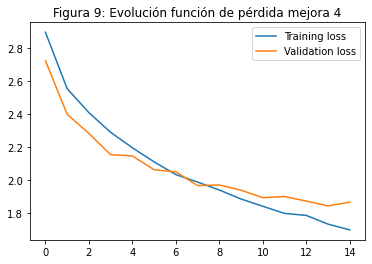

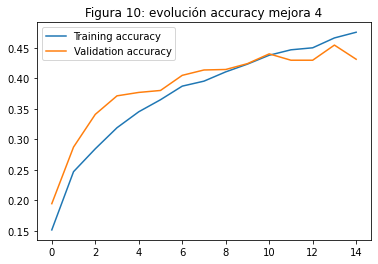

In [12]:
# ____Compilado modelo _____
modeloModificacion4.compile( loss = keras.losses.categorical_crossentropy,
              optimizer = optimizador,
              metrics = ["accuracy"] )

# ______Entrenamiento del ModeloMejora3_____
# valor por defecto para batch_size en keras al hacer
tam_batch = 32

# número de epocas a entrenar el modelo
epocas = 15

# reestablecemos los pesos
evolucion_entrenamiento_mejora4 = modeloModificacion4.fit(
    x_train_normalizados, y_train,
    validation_data=(x_validation_normalizados, y_validation),
    epochs=epocas,
    verbose=True
)

mostrarEvolucion(evolucion_entrenamiento_mejora4, 'Figura 9: Evolución función de pérdida mejora 4', 'Figura 10: evolución accuracy mejora 4')

### Conclusiones mejora 4  
Como se aprecia, el sobreentrenamiento ha sido considerablemente reducido ya que como podemos ver en las *figuras 9 y 10* los errores de entrenamiento y validación se mantienen muy próximos. 

Lo que nos sugiere que aumentar el número de épocas mejoraría el resultado, como apriori no sabremos cuántas pondremos en marcha el early stopping.

### Mejora 5 Early Stopping 
Bibliografía: 
- [19] Documentación de keras título: *EarlyStopping*  url: https://keras.io/api/callbacks/early_stopping/ fecha de consulta: 22-12-21  


Según [19] es un callback que para el entrenamiento cuando la métrica de erro ya no está mejorando. 
La configuraremos para que dependa del accuracy de validación (argumento `monitor`) tras tres épocas (`patiente=3`) sin mejorar, este valor es una heurística, ya que el resto de modelos (ver por ejemplo *figura 7*) veíamos que con 15 épocas el error de validación empeoraba por el sobreentrenamiento y que asintóricamente este ya se podía predecir con tres épocas. 


Epoch 1/50
  1/352 [..............................] - ETA: 1:54 - loss: 4.0461 - accuracy: 0.0312

2021-12-24 19:21:54.561099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - ETA: 0s - loss: 2.9256 - accuracy: 0.1500

2021-12-24 19:21:59.407904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 5s 14ms/step - loss: 2.9256 - accuracy: 0.1500 - val_loss: 2.6596 - val_accuracy: 0.2288
Epoch 2/50
352/352 [==============================] - 5s 14ms/step - loss: 2.5833 - accuracy: 0.2362 - val_loss: 2.4803 - val_accuracy: 0.2736
Epoch 3/50
352/352 [==============================] - 5s 14ms/step - loss: 2.4439 - accuracy: 0.2716 - val_loss: 2.3234 - val_accuracy: 0.3208
Epoch 4/50
352/352 [==============================] - 5s 14ms/step - loss: 2.3458 - accuracy: 0.3001 - val_loss: 2.2473 - val_accuracy: 0.3376
Epoch 5/50
352/352 [==============================] - 5s 14ms/step - loss: 2.2482 - accuracy: 0.3290 - val_loss: 2.1826 - val_accuracy: 0.3432
Epoch 6/50
352/352 [==============================] - 5s 15ms/step - loss: 2.1952 - accuracy: 0.3436 - val_loss: 2.1448 - val_accuracy: 0.3744
Epoch 7/50
352/352 [==============================] - 5s 14ms/step - loss: 2.1323 - accuracy: 0.3566 - val_loss: 2.0841 - val_accuracy: 0.3864
Epoch 8/50

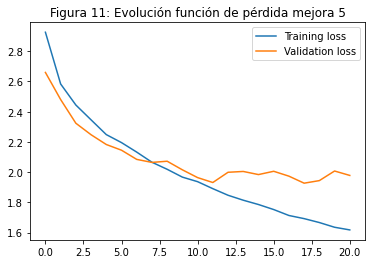

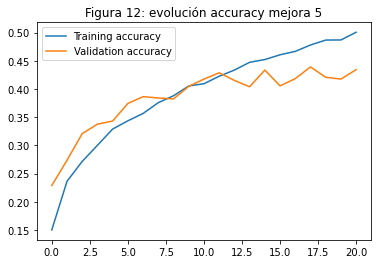

In [18]:

## Implementamos el EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

modeloModificacion5 = ModeloModificacion4().create_model()
# ____Compilado modelo _____
modeloModificacion5.compile( loss = keras.losses.categorical_crossentropy,
              optimizer = optimizador,
              metrics = ["accuracy"] )

# ______Entrenamiento del ModeloMejora3_____
# valor por defecto para batch_size en keras al hacer
tam_batch = 32
# número de épocas máximas a entrenar el modelo
epocas = 50
# reestablecemos los pesos
evolucion_entrenamiento_mejora5 = modeloModificacion5.fit(
    x_train_normalizados, y_train,
    validation_data=(x_validation_normalizados, y_validation),
    epochs=epocas,
    verbose=True,
    callbacks=[callback]
)

mostrarEvolucion(evolucion_entrenamiento_mejora5, 'Figura 11: Evolución función de pérdida mejora 5', 'Figura 12: evolución accuracy mejora 5')

# Conclusiones  

Podemos ver por la *figuras 11 y 12* que se ha parado la ejecución antes de que se produjera un sobreentrenamiento. 
Esto ha sido tras 21 épocas y alcanzando unos resultados de `5s 14ms/step - loss: 1.6174 - accuracy: 0.5007 - val_loss: 1.9780 - val_accuracy: 0.4344`. 


Haciendo recopilación de todos los resultados se tiene que: 

*Tabla 9*: Resumen de resultados tras segunda mejora  

Modelo | Accuracy en validación  | Tiempo empleado por época | Valor función pérdida en validación | Accuracy entrenamiento  
:-: | :-:  | :-: | :-: | :-:
Modelo básico |  0.4224 | 3s | 2.035 | 0.5114
Mejora 1 |  0.4664|  4s  | 1.9441  | 0.6010  
Mejora 2  | 0.2096 | 4s | 2.6681 | 0.4121
Mejora 3 | 0.4688  |4s  |2.9909 | 0.8693  
Majora 4 | 0.4312 | 5s | 1.8679 | 0.4755 
Mejora 5 | 0.4344 |5s  |1.9780 |  0.5007  


*Tabla 10*: Resumen de mejoras progresivas  

Modelo  | Mejora con respecto al modelo anterior
---| ---  
Modelo básico | Modelo inicial descrito en apartado primero  
Mejora 1 | Normalizamos por *featurewise* los datos de entrada: ahora la media y desviación típica son 0    
Mejora 2 | Aumento de los datos    
Mejora 3 | Aumento de la profundidad de las capas  
Mejora 4 | Normalización  
Mejora 5 | Early Stopping  

Podemos observar que Early Stopping ha afinado un poco más nuestros resultados (aunque añadido mayor error en validación), el cambio ha sido poco, y esto se ha debido a que se
ha alcanzado la parad apocas épocas después (se ha pasado de 15 a 21). 

Si tuviéramos que elegir un modelo que entrenar, puede observarse que la *mejora 3* tiene mejor error en accuracy en validación, pero sin embargo el sobreentrenamiento es mayor, conjunto con el error de la función de pérdida, es por ello que descartaría ese modelo.   

Cabe destacar entonces que ya la *primera mejora* es un buen candidato también por los mismos motivos, pero por tener algo más de sobreentramiento que el modelo quinto nos quedaremos con el cuarto. 

# Calculamos los resultados en test 

In [15]:
#########################################################################
################ PREDICCIÓN SOBRE EL CONJUNTO DE TEST ###################
#########################################################################

#Incluir model.evaluate() 
prediccion = modeloModificacion4.predict(x_test_normalizados, batch_size = tam_batch, verbose = 1)
#Incluir función que muestre la perdida y accuracy del test
precision_test = calcularAccuracy(y_test, prediccion)
print("Accuracy en el conjunto test: {}".format(precision_test))

71/79 [=========================>....] - ETA: 0s

2021-12-24 19:13:51.006775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 6ms/step
Accuracy en el conjunto test: 0.4612


# Conclusiones  

**Modelo cuarto** ha sido el seleccionado y ha obtenido : 0.4312,  de accuracy en validación,  0.4755  en entrenamiento y un **0.412 en test**. 
Como vemos muy próximo a los datos de entrenamiento y validación, luego nuestra heurística de seleccionar un modelo que no tuviera sobreentrenamiento ha sido correcta. 

Otras conclusiones que obtenemos tras estos ejercicios es que existen infinitos ajustes posibles y ninguna fórmula exacta que utilizar. Para solventar este problema nosotros hemos optado por inspirarnos en las primeras redes de clasificación exitosas. No hemos querido imitar redes actuales o mejoras de las otras por nuestras limitaciones de recursos: tanto por el tamaño del dataset en que nos basamos como en nuestra potencia computacional. 


# Bibliografía consultada 

- [1] Oficial de keras sobre *optimizers* consultada a día 19-12-21: https://keras.io/api/optimizers/  

- [2] Artículo: *Comparative Study of First Order Optimizers for
Image Classification Using Convolutional Neural
Networks on Histopathology Images* de autores *Ibrahem Kandel, Mauro Castelli and Aleš Popoviˇ* Publicado el 8 de septiembre de 2020. DOI:  https://doi.org/10.3390/jimaging6090092  

- [3] Saleem MH, Potgieter J, Arif KM. Plant Disease Classification: A Comparative Evaluation of Convolutional Neural Networks and Deep Learning Optimizers. Plants (Basel). 2020 Oct 6;9(10):1319. doi: 10.3390/plants9101319. PMID: 33036220; PMCID: PMC7599959.

- [4] Yaqub M,Jinchao F, Zia M. State-of-the-Art CNN Optimizer for Brain Tumor Segmentation in Magnetic Resonance Images. Brain Sci. 2020 Jul 3;10(7):427. doi: 10.3390/brainsci10070427.

- [5] Oficial de keras sobre el optimizador Adam, consultado a días 19-12-21: https://keras.io/api/optimizers/adam/

- [6] Documentación oficial de keras sobre *Model training APIs*, consultada el 19-12-21: https://keras.io/api/models/model_training_apis/

- [7] Documentación oficial de keras sobre *Losses*, consultada el 19-12-21: https://keras.io/api/losses/  

- [8] Documentación oficial de keras sobre *CategoricalCrossentropy class*, consultada el 19-12-21: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class

- [9] Documentación oficial de keras consultada sobre la clase sequential a día 18-12-2021: https://keras.io/api/models/sequential/  

- [10] Documentación oficial de keras obre convolución consultada a día 18-12-2021: https://keras.io/api/layers/convolution_layers/convolution2d/  

- [11] Documentación oficial de keras sobre las funciones de activación día 18-12-21: https://keras.io/api/layers/activations/  

- [12] Página oficial de keras: Maxpooling 2d, consultada a día 18-12-21
https://keras.io/api/layers/pooling_layers/max_pooling2d/  

- [13] Documentación oficial de keras sobre *flatten layer*, consultada a día 18-12-21: https://keras.io/api/layers/reshaping_layers/flatten/ 

- [14] Oficial de keras sobre *softmax*, consultada a día 18-12-21:
https://keras.io/api/layers/activation_layers/softmax/   

- [15] Bridle, J.S. (1990a). Probabilistic Interpretation of Feedforward
   Classification Network Outputs, with Relationships to Statistical Pattern
   Recognition. In: F.Fogleman Soulie and J.Herault (eds.), Neurocomputing:
   Algorithms, Architectures and Applications, Berlin: Springer-Verlag, pp.
   227-236.   

- [16] Página oficia de tensorflow, sobre ImageDataGenerator https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator consultada a día 20-12-21  
- [17] Página web toward data science, título: *Understanding and Implementing LeNet-5 CNN Architecture (Deep Learning)* url: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342 consultada a día 21-12-21 . 
- [18] Página web analyticsvidhya, titulo: *Introduction to The Architecture of Alexnet* url: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/ consultada a día 22-12-21.


